This code is taken from a kernel by I,coder on the Titanic dataset from kaggle

https://www.kaggle.com/ash316/eda-to-prediction-dietanic

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
data=pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

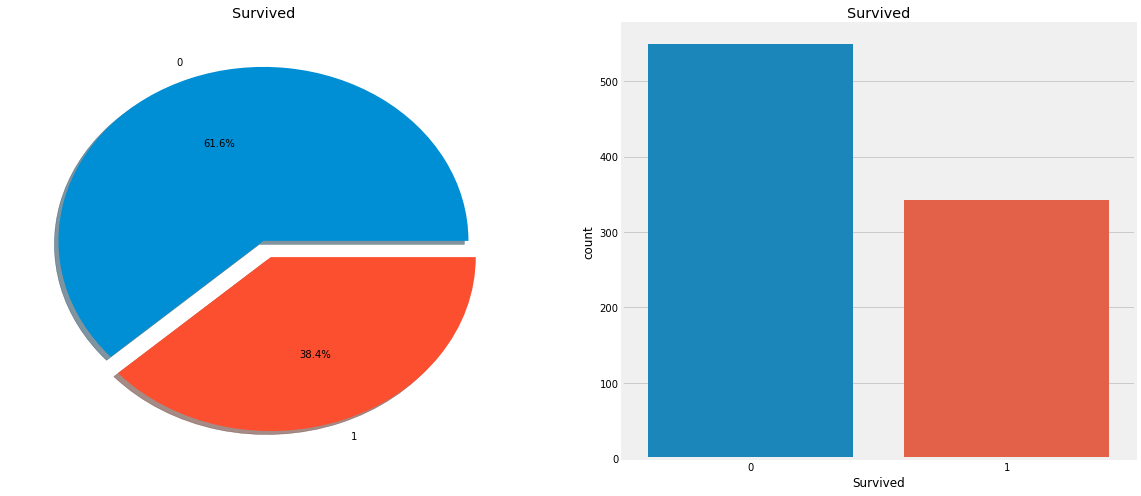

In [3]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=data,ax=ax[1])
ax[1].set_title('Survived')
plt.show()



In [4]:
data.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

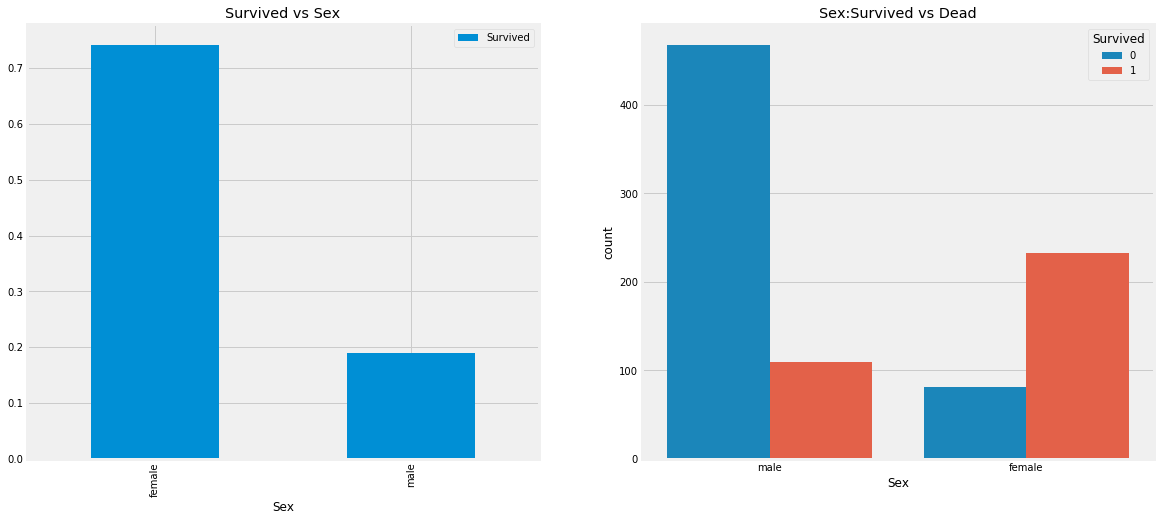

In [5]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Sex:Survived vs Dead')
plt.show()

In [6]:
pd.crosstab(data.Pclass,data.Survived,margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


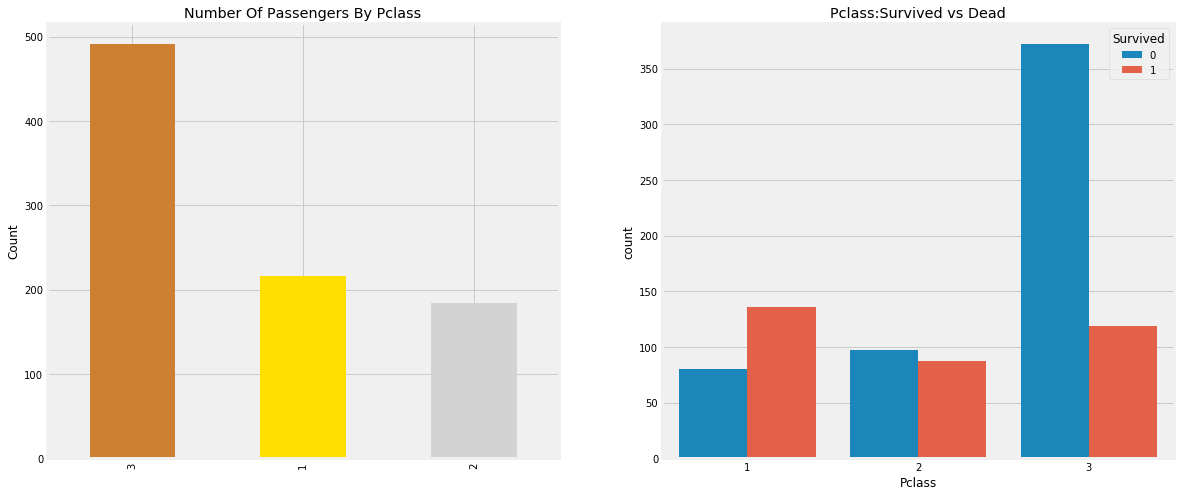

In [7]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot('Pclass',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

In [8]:
pd.crosstab([data.Sex,data.Survived],data.Pclass,margins=True).style.background_gradient(cmap='summer_r')

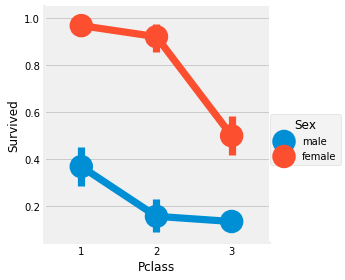

In [9]:
sns.factorplot('Pclass','Survived',hue='Sex',data=data)
plt.show()

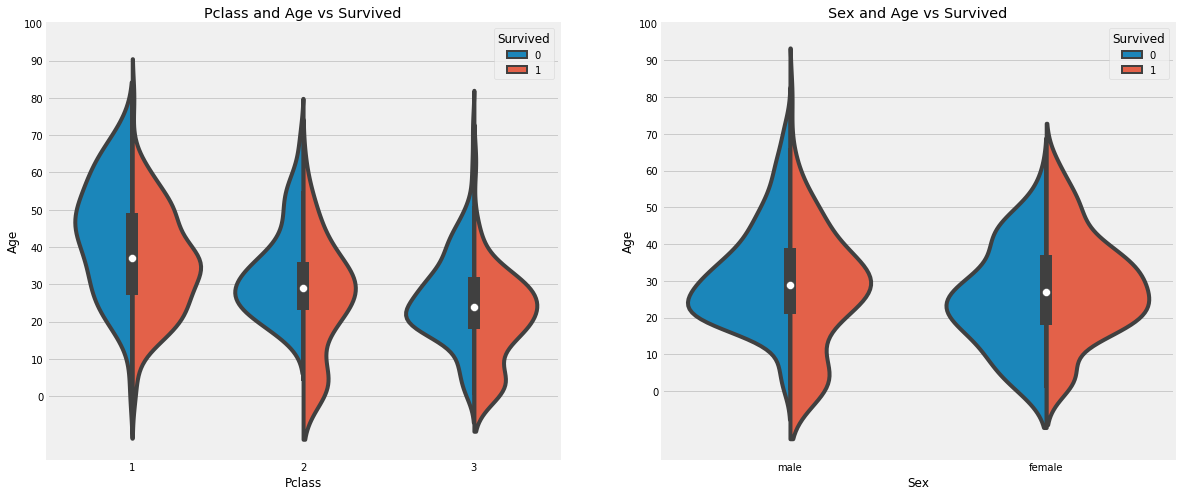

In [10]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age", hue="Survived", data=data,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age", hue="Survived", data=data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

In [11]:
data['Title']=0
for i in data:
    data['Title']=data.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

In [12]:
pd.crosstab(data.Title,data.Sex).T.style.background_gradient(cmap='summer_r') #Checking the Initials with the Sex

Title,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [13]:
  data['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don']
                        ,['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)



In [14]:
data.groupby('Title')['Age'].median() #lets check the average age by Initials

Title
Master     3.5
Miss      21.5
Mr        30.0
Mrs       35.0
Other     51.0
Name: Age, dtype: float64

In [15]:
data.loc[(data.Age.isnull())&(data.Title=='Mr'),'Age']=30
data.loc[(data.Age.isnull())&(data.Title=='Mrs'),'Age']=35
data.loc[(data.Age.isnull())&(data.Title=='Master'),'Age']=3
data.loc[(data.Age.isnull())&(data.Title=='Miss'),'Age']=21
data.loc[(data.Age.isnull())&(data.Title=='Other'),'Age']=51

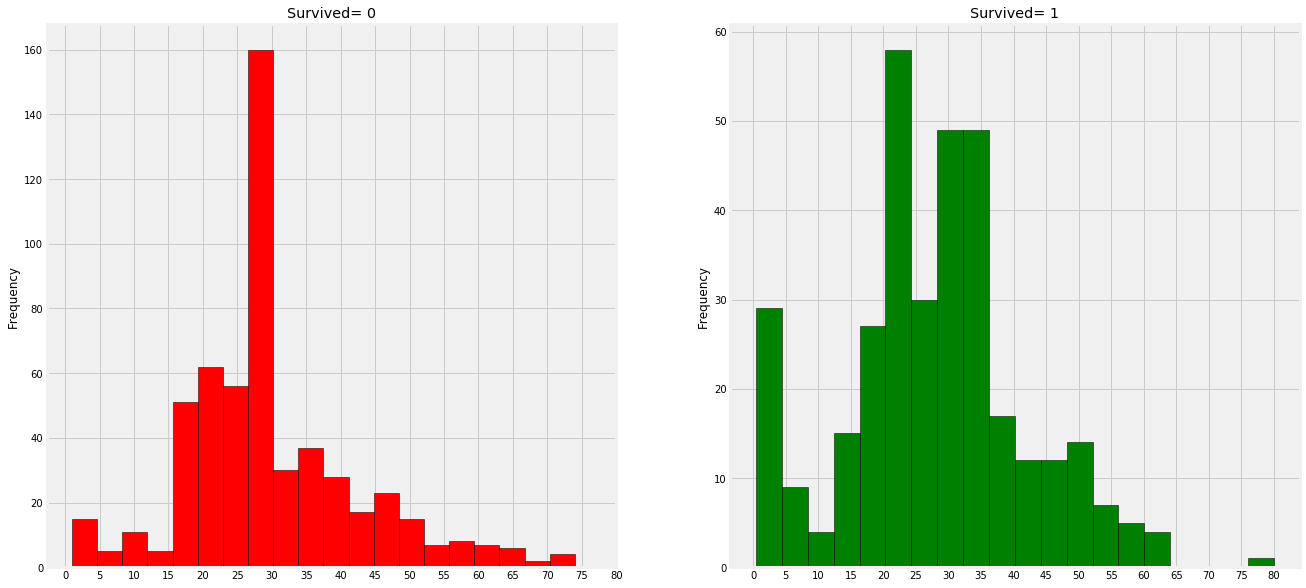

In [16]:
f,ax=plt.subplots(1,2,figsize=(20,10))
data[data['Survived']==0].Age.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('Survived= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
data[data['Survived']==1].Age.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('Survived= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

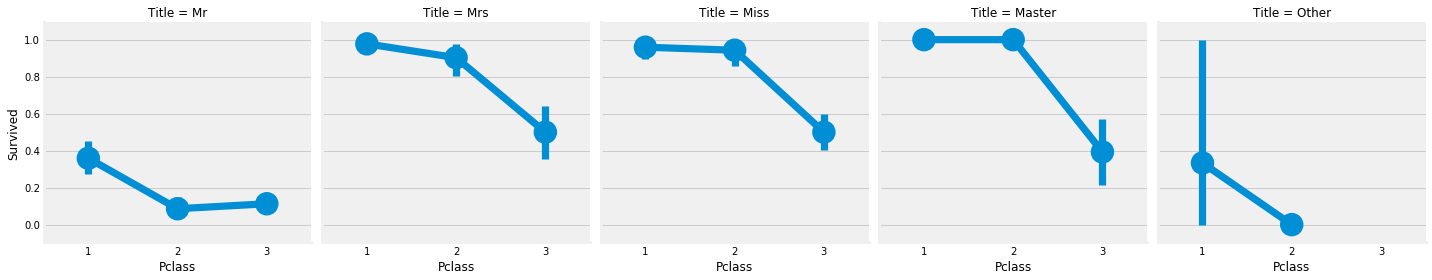

In [17]:
sns.factorplot('Pclass','Survived',col='Title',data=data)
plt.show()


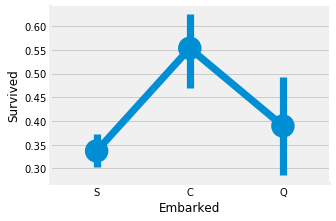

In [18]:
sns.factorplot('Embarked','Survived',data=data)
fig=plt.gcf()
fig.set_size_inches(5,3)
plt.show()



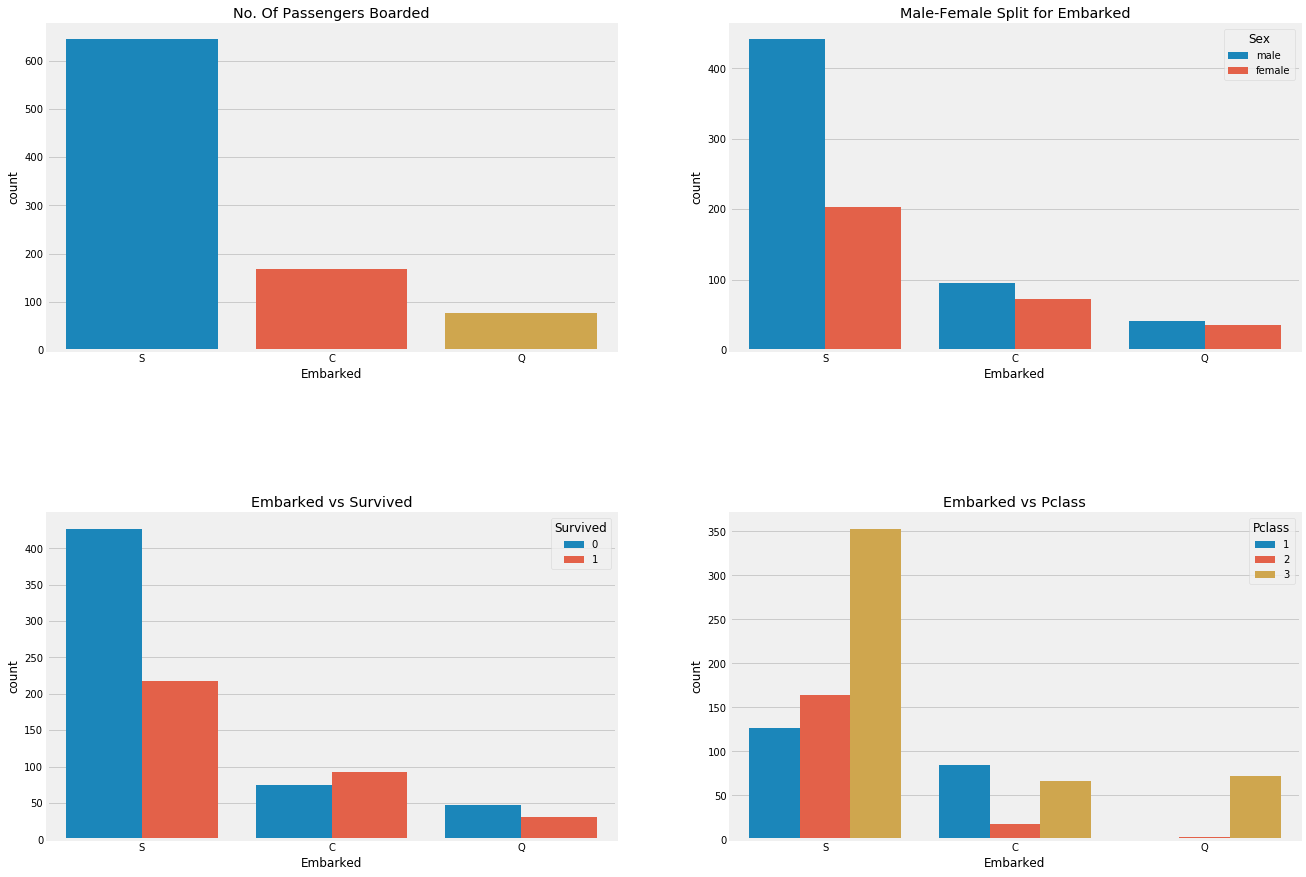

In [19]:
f,ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot('Embarked',data=data,ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')
sns.countplot('Embarked',hue='Sex',data=data,ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')
sns.countplot('Embarked',hue='Survived',data=data,ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')
sns.countplot('Embarked',hue='Pclass',data=data,ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

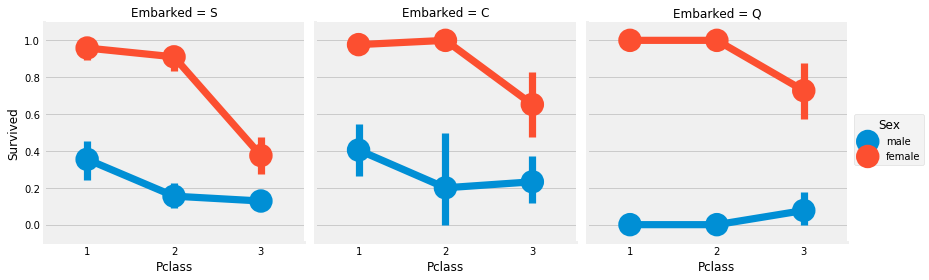

In [20]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=data)
plt.show()


In [21]:
data['Embarked'].fillna('S',inplace=True)

In [22]:
pd.crosstab([data.SibSp],data.Survived).style.background_gradient(cmap='summer_r')

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


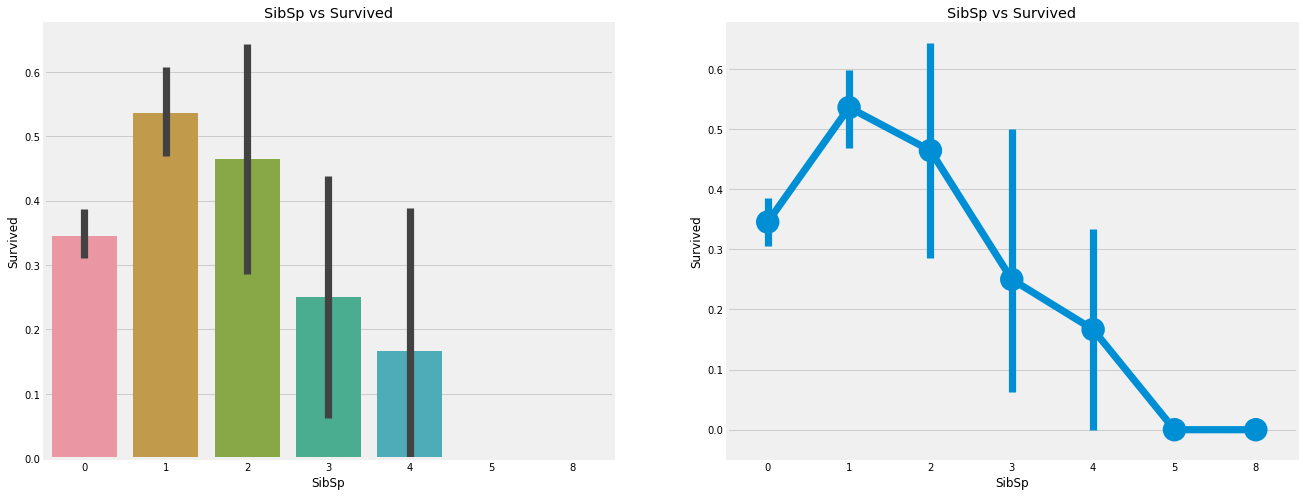

In [23]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('SibSp','Survived',data=data,ax=ax[0])
ax[0].set_title('SibSp vs Survived')
sns.factorplot('SibSp','Survived',data=data,ax=ax[1])
ax[1].set_title('SibSp vs Survived')
plt.close(2)
plt.show()

In [24]:
pd.crosstab(data.SibSp,data.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


In [25]:
pd.crosstab(data.Parch,data.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


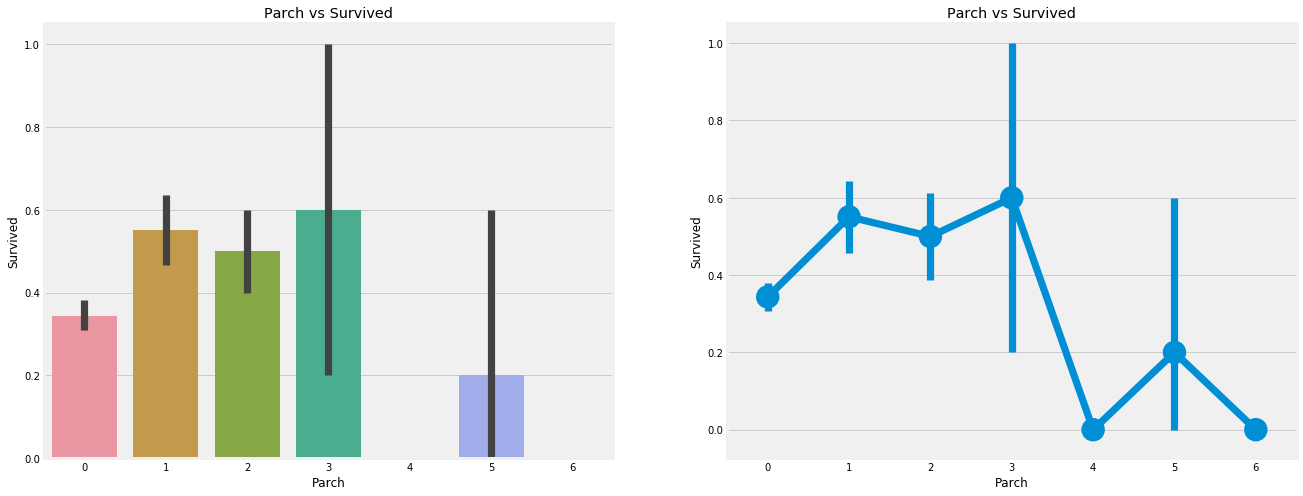

In [26]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('Parch','Survived',data=data,ax=ax[0])
ax[0].set_title('Parch vs Survived')
sns.factorplot('Parch','Survived',data=data,ax=ax[1])
ax[1].set_title('Parch vs Survived')
plt.close(2)
plt.show()

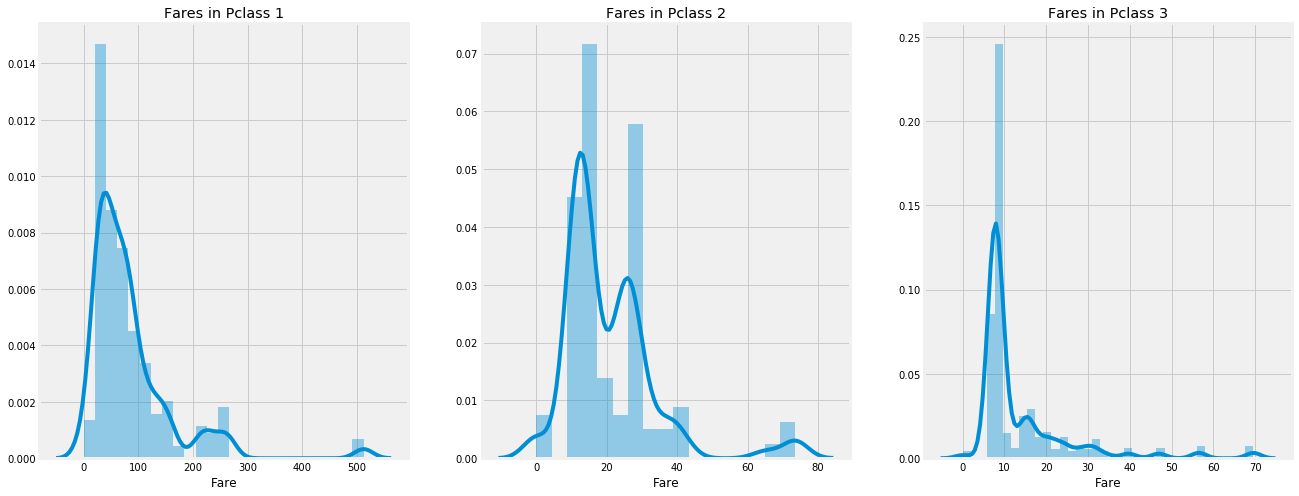

In [27]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(data[data['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(data[data['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(data[data['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

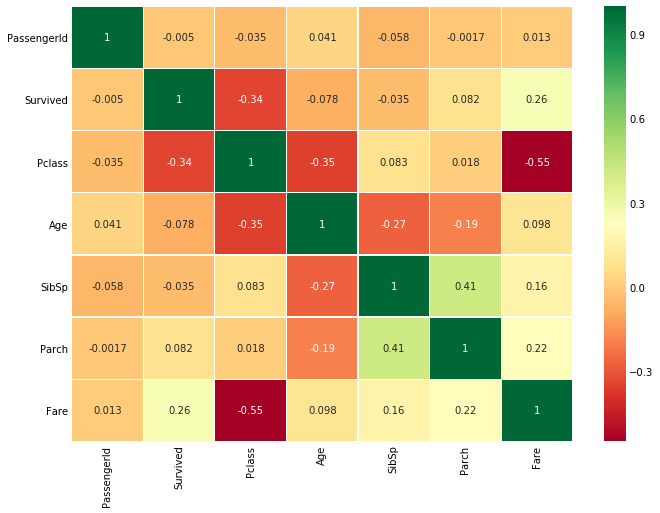

In [28]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [29]:
data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2


In [30]:
#checking the number of passenegers in each band
data['Age_band'].value_counts().to_frame().style.background_gradient(cmap='summer')



,Age_band
1,502
2,205
0,104
3,69
4,11


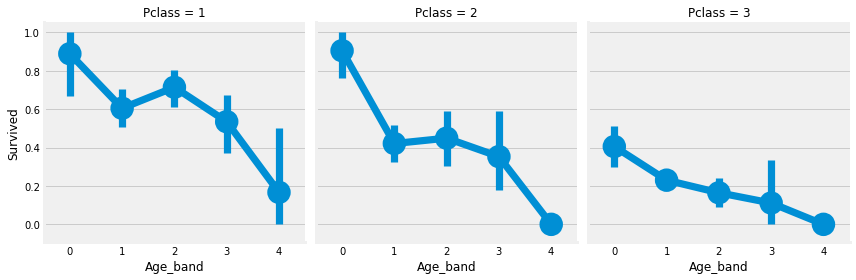

In [31]:
sns.factorplot('Age_band','Survived',data=data,col='Pclass')
plt.show()

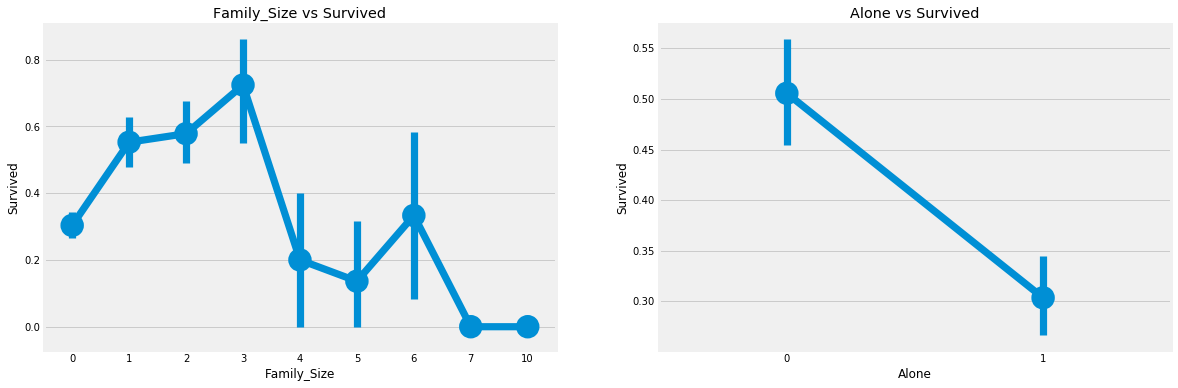

In [32]:
data['Family_Size']=0
data['Family_Size']=data['Parch']+data['SibSp']#family size
data['Alone']=0
data.loc[data.Family_Size==0,'Alone']=1#Alone

f,ax=plt.subplots(1,2,figsize=(18,6))
sns.factorplot('Family_Size','Survived',data=data,ax=ax[0])
ax[0].set_title('Family_Size vs Survived')
sns.factorplot('Alone','Survived',data=data,ax=ax[1])
ax[1].set_title('Alone vs Survived')
plt.close(2)
plt.close(3)
plt.show()

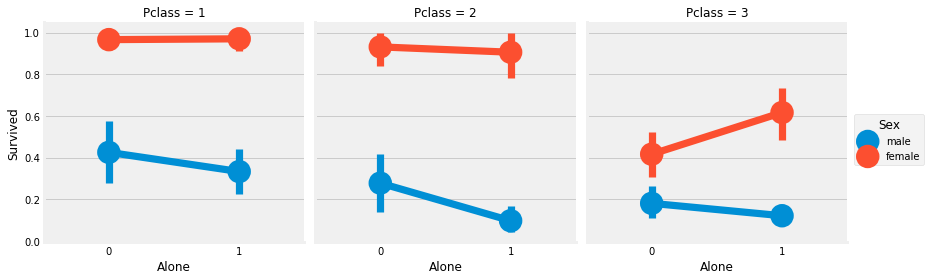

In [33]:
sns.factorplot('Alone','Survived',data=data,hue='Sex',col='Pclass')
plt.show()

In [34]:
data['Fare_Range']=pd.qcut(data['Fare'],4)
data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


In [35]:
data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

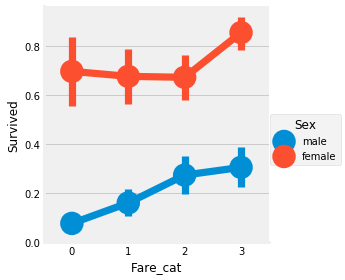

In [36]:
sns.factorplot('Fare_cat','Survived',data=data,hue='Sex')
plt.show()

In [37]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Title'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

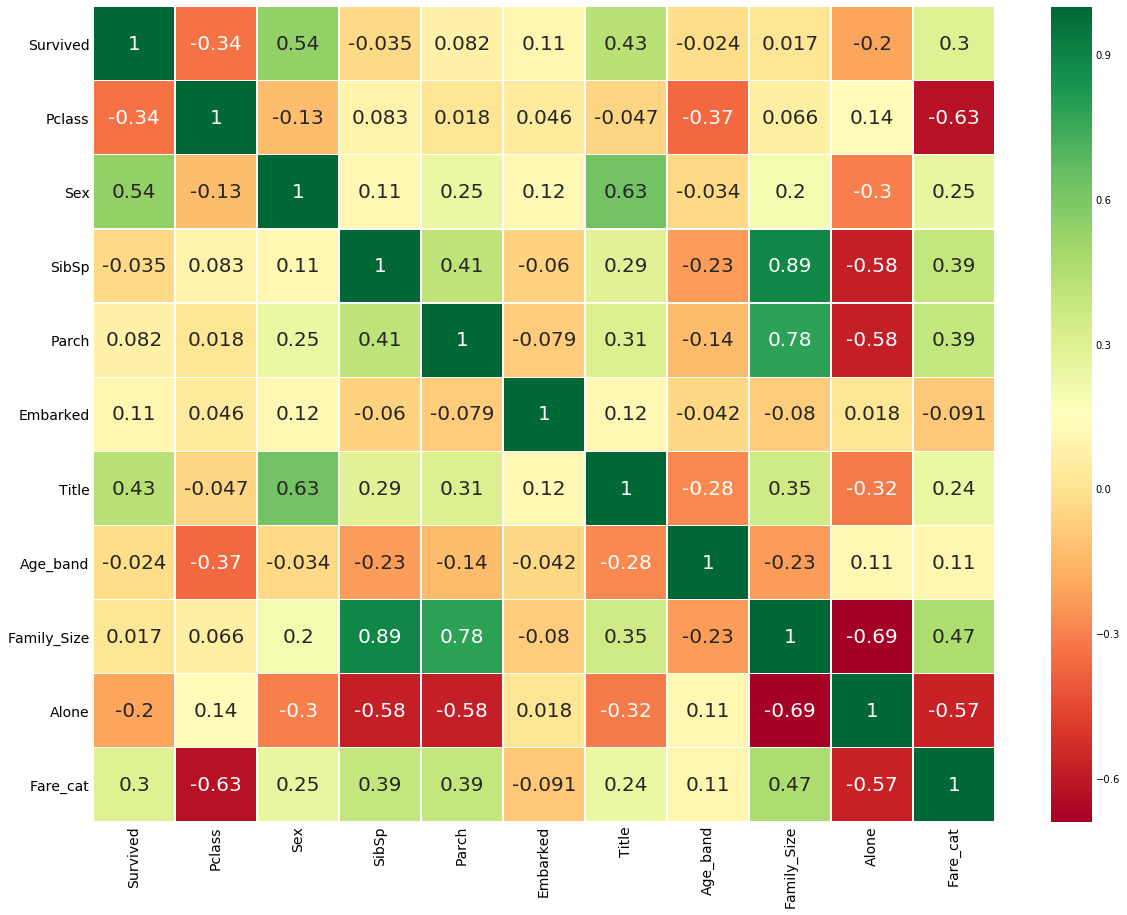

In [38]:
data.drop(['Name','Age','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1,inplace=True)
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [39]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

In [40]:
train,test=train_test_split(data,test_size=0.3,random_state=0,stratify=data['Survived'])

train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]

test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]

X=data[data.columns[1:]]
Y=data['Survived']


In [41]:
model=svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(train_X,train_Y)
prediction1=model.predict(test_X)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction1,test_Y))

Accuracy for rbf SVM is  0.835820895522


In [42]:
model=svm.SVC(kernel='linear',C=0.1,gamma=0.1)
model.fit(train_X,train_Y)
prediction2=model.predict(test_X)
print('Accuracy for linear SVM is',metrics.accuracy_score(prediction2,test_Y))

Accuracy for linear SVM is 0.817164179104


In [43]:
model = LogisticRegression()
model.fit(train_X,train_Y)
prediction3=model.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,test_Y))

The accuracy of the Logistic Regression is 0.813432835821


In [44]:
model=DecisionTreeClassifier()
model.fit(train_X,train_Y)
prediction4=model.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,test_Y))

The accuracy of the Decision Tree is 0.798507462687


In [45]:
model=KNeighborsClassifier() 
model.fit(train_X,train_Y)
prediction5=model.predict(test_X)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction5,test_Y))

The accuracy of the KNN is 0.839552238806


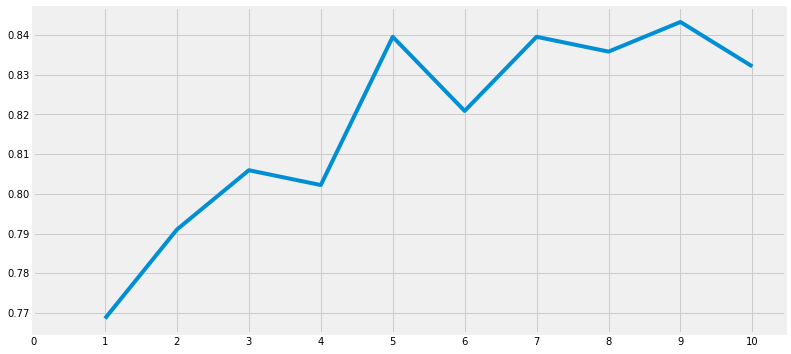

Accuracies for different values of n are: [ 0.76865672  0.79104478  0.80597015  0.80223881  0.83955224  0.82089552
  0.83955224  0.8358209   0.84328358  0.83208955] with the max value as  0.84328358209


In [46]:
a_index=list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model=KNeighborsClassifier(n_neighbors=i) 
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    a=a.append(pd.Series(metrics.accuracy_score(prediction,test_Y)))
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:',a.values,'with the max value as ',a.values.max())

In [47]:
model=GaussianNB()
model.fit(train_X,train_Y)
prediction6=model.predict(test_X)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction6,test_Y))

The accuracy of the NaiveBayes is 0.809701492537


In [48]:
model=RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y)
prediction7=model.predict(test_X)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction7,test_Y))


The accuracy of the Random Forests is 0.813432835821


In [49]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,Y, cv = kfold,scoring = "accuracy")
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2


,CV Mean,Std
Linear Svm,0.791223,0.045646
Radial Svm,0.828290,0.034427
Logistic Regression,0.800212,0.024081
KNN,0.814919,0.044922
Decision Tree,0.813720,0.020543
Naive Bayes,0.798027,0.031400
Random Forest,0.818240,0.032837


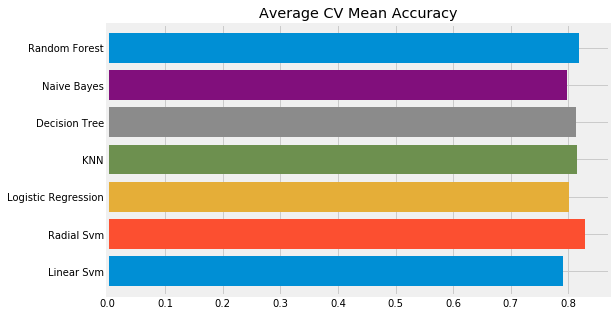

In [50]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()


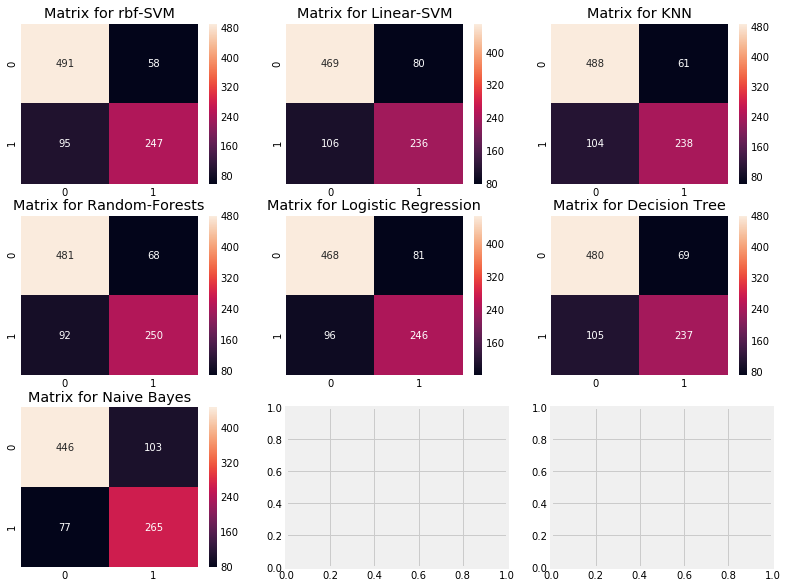

In [51]:
f,ax=plt.subplots(3,3,figsize=(12,10))
y_pred = cross_val_predict(svm.SVC(kernel='rbf'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')
y_pred = cross_val_predict(svm.SVC(kernel='linear'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')
y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')
y_pred = cross_val_predict(LogisticRegression(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')
y_pred = cross_val_predict(DecisionTreeClassifier(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')
y_pred = cross_val_predict(GaussianNB(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

In [52]:
from sklearn.model_selection import GridSearchCV
C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kernel=['rbf','linear']
hyper={'kernel':kernel,'C':C,'gamma':gamma}
gd=GridSearchCV(estimator=svm.SVC(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
0.828282828283
SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:   13.0s finished


In [53]:
n_estimators=range(100,1000,100)
hyper={'n_estimators':n_estimators}
gd=GridSearchCV(estimator=RandomForestClassifier(random_state=0),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   19.5s finished


0.817059483726
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [54]:
from sklearn.ensemble import VotingClassifier


ensemble_lin_rbf=VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
                                              ('RBF',svm.SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
                                              ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
                                              ('LR',LogisticRegression(C=0.05)),
                                              ('DT',DecisionTreeClassifier(random_state=0)),
                                              ('NB',GaussianNB()),
                                              ('svm',svm.SVC(kernel='linear',probability=True))
                                             ], 
                       voting='soft').fit(train_X,train_Y)
print('The accuracy for ensembled model is:',ensemble_lin_rbf.score(test_X,test_Y))
cross=cross_val_score(ensemble_lin_rbf,X,Y, cv = 10,scoring = "accuracy")
print('The cross validated score is',cross.mean())


The accuracy for ensembled model is: 0.820895522388
The cross validated score is 0.822680172512


In [55]:
from sklearn.ensemble import BaggingClassifier
model=BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),random_state=0,n_estimators=700)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The accuracy for bagged KNN is:',metrics.accuracy_score(prediction,test_Y))
result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged KNN is:',result.mean())

The accuracy for bagged KNN is: 0.828358208955
The cross validated score for bagged KNN is: 0.822717058223


In [56]:
model=BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=0,n_estimators=100)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The accuracy for bagged Decision Tree is:',metrics.accuracy_score(prediction,test_Y))
result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged Decision Tree is:',result.mean())

The accuracy for bagged Decision Tree is: 0.820895522388
The cross validated score for bagged Decision Tree is: 0.822717058223


In [57]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
result=cross_val_score(ada,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoost is:',result.mean())

The cross validated score for AdaBoost is: 0.823829020543


In [58]:
from sklearn.ensemble import GradientBoostingClassifier
grad=GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
result=cross_val_score(grad,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for Gradient Boosting is:',result.mean())

The cross validated score for Gradient Boosting is: 0.813803768017


In [59]:
import xgboost as xg
xgboost=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
result=cross_val_score(xgboost,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for XGBoost is:',result.mean())

The cross validated score for XGBoost is: 0.812717909431


In [60]:
n_estimators=list(range(100,1100,100))
learn_rate=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
hyper={'n_estimators':n_estimators,'learning_rate':learn_rate}
gd=GridSearchCV(estimator=AdaBoostClassifier(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  4.9min finished


0.83164983165
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.05, n_estimators=200, random_state=None)


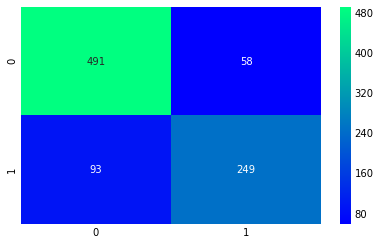

In [61]:
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.05)
result=cross_val_predict(ada,X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,result),cmap='winter',annot=True,fmt='2.0f')
plt.show()

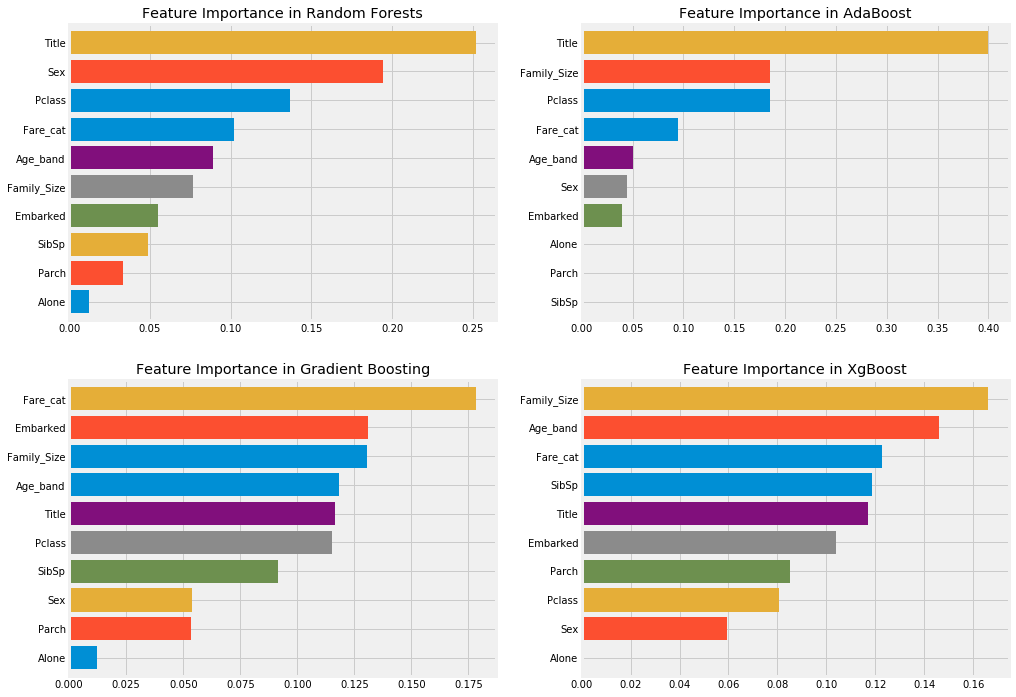

In [62]:
f,ax=plt.subplots(2,2,figsize=(15,12))
model=RandomForestClassifier(n_estimators=500,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')
model=AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1])
ax[0,1].set_title('Feature Importance in AdaBoost')
model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0])
ax[1,0].set_title('Feature Importance in Gradient Boosting')
model=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1])
ax[1,1].set_title('Feature Importance in XgBoost')